# Near-surface max wind speed data wrangle
### Takes CSIRO CMIP6 Application-Ready Gridded Climate Data NetCDF daily time series, summarises by health district using population-weighted averaging, and outputs this average as a daily time series for all health districts.

#### <i> https://data.csiro.au/collection/csiro:64206 </i>

In [2]:
import xarray as xr
import utils.agcd_agg_functions as agg
from importlib import reload
from shapely.geometry import mapping, box
import geopandas as gpd
import rioxarray
import numpy as np
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
import dill
import pandas as pd
from pathlib import Path
from collections import defaultdict

pd.set_option('display.max_columns',  None)

reload(agg)

<module 'utils.agcd_agg_functions' from 'c:\\Users\\jake.allen.ALLUVIUMQLD\\Documents\\Repos\\climate_health_reference_manual\\utils\\agcd_agg_functions.py'>

### Load datasets
We load everything into xarray dataset definitions for easy iterations later. Note that no data is being held in memory yet thanks to dask. This only happens once computations are triggered.

In [3]:
# build path dictionary
clim_fold = 'E:/Jake_ClimateRasters'

def nested_dict():
    return defaultdict(lambda: defaultdict(list))

path_dict = defaultdict(lambda: defaultdict(nested_dict))

#models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'CMCC-ESM2', 'CNRM-ESM2-1', 'EC-Earth3', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']
models = ['ACCESS-CM2']
ssps = ['ssp245']
epochs = ['mid']
variables = ['sfcWindmax']

# assign model paths
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            thisepoch = '2035-2064' if epoch == 'mid' else '2070-2099'
            for thisvar in variables:
                thispath = Path(f'{clim_fold}/{model}/{ssp}/{thisvar}/AUS-11/{thisepoch}')
                ncdfs = []
                for path in thispath.rglob('*.nc'):
                    ncdfs.append(path)
                path_dict[model][ssp][epoch][thisvar] = ncdfs

# assign historical observation paths
for thisvar in variables:
    thispath = Path(f'{clim_fold}/Historical/{thisvar}')
    ncdfs = []
    for path in thispath.rglob('*.nc'):
        ncdfs.append(path)
    path_dict['Historical'][thisvar] = ncdfs

In [4]:
# load districts

districts = gpd.read_file('Inputs/health_district_merged.json')

#subset districts if necessary
#districts = districts[districts['health_district_name'].isin(['Northern NSW', 'Western Sydney', 'Eyre and Far North'])].copy().to_crs('EPSG:4326')

# get bounding box
minx, miny, maxx, maxy = districts.total_bounds

bbox_geom = box(minx, miny, maxx, maxy)
bbox = [mapping(bbox_geom)]

In [5]:
# Load ncdfs into dictionary for easy wrangling, subsetting to bounding box and chunking by time = 365
# use load_var helper function

# initialise empty dictionary
data_dict = defaultdict(lambda: defaultdict(nested_dict))

# load model data
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = xr.Dataset({
                thisvar: agg.load_var(path_dict[model][ssp][epoch][thisvar], thisvar, bbox)
                for thisvar in variables
            })
            data_dict[model][ssp][epoch] = ds


# Load all historical variables into a dict
# historical data has misaligned time coordinates, causing issues when combining into a single dataset
hist_vars = {}
for thisvar in variables:
    ds = agg.load_var(path_dict['Historical'][thisvar], thisvar, bbox, chunk=False)

    # Force matching time coordinates
    if 'time' in hist_vars:
        ds['time'] = hist_vars['time']
    else:
        hist_vars['time'] = ds['time']

    hist_vars[thisvar] = ds

# Drop the saved 'time' array from the dict
hist_vars.pop('time')

# Now build the dataset
data_dict['Historical'] = xr.Dataset(hist_vars)

### Population weighting - prepare raster (reproject, resample and align to ncdfs)

In [6]:
# open population raster
pop = rioxarray.open_rasterio("Inputs/australian_pop_grid_2024/apg24e_1_0_0.tif").squeeze() # remove band dimension

# ensure correct projections are assinged (GDA94 for pop grid, WGS 84 for netcdfs)
pop.rio.write_crs("EPSG:3577", inplace=True)
# convert -1 to NaN and set as no data
pop = pop.where(pop != -1, np.nan)
pop = pop.rio.write_nodata(np.nan, inplace=False)

ref = data_dict['Historical']['sfcWindmax'].isel(time=0)
ref.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)

# reproject and resample, summing values as the resample method
pop_aligned = pop.rio.reproject_match(
    ref,
    resampling=Resampling.sum)

# rename dimensions and coords
pop_aligned = pop_aligned.rename({'x': 'lon', 'y': 'lat'})

### Population weighting - prepare district polygons (reproject and extract transformation, create column name)

In [8]:
all_districts = districts.to_crs(pop_aligned.rio.crs)
all_districts['district_name_id'] = all_districts['state'] + '_' +  all_districts['health_district_name']

affine = pop_aligned.rio.transform()

### Population weighting - Run weighting and generate time series tables

In [9]:
# loop through all model datasets (not historical)

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            for thisvar in variables:
                # retrieve dataset from dictionary
                ds = data_dict[model][ssp][epoch][thisvar]
                # create time series dataset using function in agg functions file
                df = agg.zonal_weighted_mean_time_series(ds, pop_aligned, all_districts, affine, 'district_name_id')

                # get time series bounds for filename
                period = "FUTURE2035-2064" if epoch == 'mid' else "FUTURE2070-2099"
                
                fname = f"{thisvar}_DailyTimeSeries_52HealthDistricts_{period}_{ssp}_{model}"

                df.to_csv(f'Outputs/sfcWindmax_weighted_means/{fname}.csv', index=False) 


PermissionError: [Errno 13] Permission denied: 'Outputs/sfcWindmax_weighted_means/sfcWindmax_DailyTimeSeries_52HealthDistricts_FUTURE2035-2064_ssp245_ACCESS-CM2.csv'

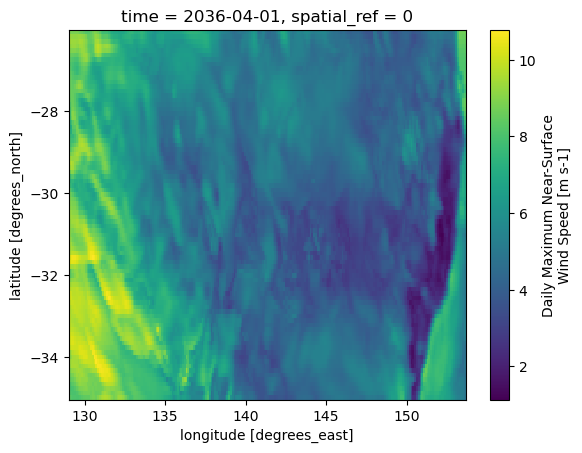

In [ ]:
# Arithmetic mean

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            for thisvar in variables:
                # retrieve dataset from dictionary
                ds = data_dict[model][ssp][epoch][thisvar]
                # create time series dataset using function in agg functions file
                df = agg.zonal_mean_time_series(ds, pop_aligned, all_districts, affine, 'district_name_id')

                # get time series bounds for filename
                period = "FUTURE2035-2064" if epoch == 'mid' else "FUTURE2070-2099"
                
                fname = f"{thisvar}_DailyTimeSeries_52HealthDistricts_{period}_{ssp}_{model}_reg_mean"

                df.to_csv(f'Outputs/sfcWindmax_weighted_means/{fname}.csv', index=False) 